In [1]:
from data_loader import PykrxDataLoader
import pandas as pd
from pykrx import stock
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

### 연도별 시가총액 상위 200개 기업리스트(2004~2024)

In [3]:
from pykrx import stock
import pandas as pd

start_year = 2005
end_year = 2024

# 결과를 저장할 리스트 생성
records = []

for year in range(start_year, end_year + 1):
    date = f"{year}-12-31"  # 연말 기준 (휴장일일 경우 이전 영업입)
    df = stock.get_market_cap_by_ticker(date, market='KOSPI',alternative=True)
    # 시가총액 상위 200개 주식코드 추출
    top200_codes = df.sort_values(by='시가총액', ascending=False).head(200).index.tolist()
    # 각 코드에 대해 연도와 함께 리스트에 저장
    for code in top200_codes:
        records.append({'연도': year, '주식코드': code})

# 리스트를 데이터프레임으로 변환
result_df = pd.DataFrame(records)

# 결과 확인
print(result_df)


        연도    주식코드
0     2005  005930
1     2005  060000
2     2005  015760
3     2005  005380
4     2005  005490
...    ...     ...
3995  2024  298020
3996  2024  011210
3997  2024  004000
3998  2024  004490
3999  2024  300720

[4000 rows x 2 columns]


### 상위 200위내에 들어온 기업의 빈도수

In [4]:
frequency = result_df['주식코드'].value_counts()
frequency_df = frequency.reset_index()
frequency_df.columns = ['주식코드', '빈도수']
print(frequency_df)
code_df = frequency_df[['주식코드']]
print(code_df)

       주식코드  빈도수
0    005930   20
1    078930   20
2    006280   20
3    021240   20
4    008770   20
..      ...  ...
436  027970    1
437  000360    1
438  003940    1
439  000800    1
440  001530    1

[441 rows x 2 columns]
       주식코드
0    005930
1    078930
2    006280
3    021240
4    008770
..      ...
436  027970
437  000360
438  003940
439  000800
440  001530

[441 rows x 1 columns]


### 한번이라도 들어온 기업들의 연도별 수익률 수집

In [5]:
import pandas as pd

start_year = 2005
end_year = 2024

records = []
for code in code_df['주식코드']:
    df = stock.get_market_ohlcv_by_date(
        f"{start_year}0101", f"{end_year}1231", code, freq='y'
    )
    if not df.empty:
        df = df[['시가', '종가']].reset_index()  # 시가 포함
        df['연도'] = df['날짜'].dt.year
        # 시가 대비 종가 변화율 계산
        df['수익률'] = ((df['종가'] - df['시가']) / df['시가'])
        records.append(df.assign(주식코드=code))

# Long-form 데이터 생성
result_df = pd.concat(records)[['주식코드', '연도', '수익률']]

# 2004년 제외
result_df = result_df.query('연도 >= 2005')

print(result_df)


      주식코드    연도       수익률
0   005930  2013 -0.103268
1   005930  2014 -0.015579
2   005930  2015 -0.059666
3   005930  2016  0.430159
4   005930  2017  0.416342
..     ...   ...       ...
7   001530  2020  1.007571
8   001530  2021  0.880176
9   001530  2022 -0.445103
10  001530  2023  0.980964
11  001530  2024  0.757645

[4688 rows x 3 columns]


In [6]:
# 1. 무한대 값을 NaN으로 변환
result_df = result_df.replace([np.inf, -np.inf], np.nan)

In [7]:
result_df.dropna(inplace=True)
result_df.to_csv("./data/rtn_data.csv", index=False)

In [8]:
pd.DataFrame(result_df[['연도']].value_counts()).sort_values(by='연도')

,count
연도,
2005,31
2006,35
2007,36
2008,38
2009,42
2010,41
2011,40
2012,37
2013,343


### 재무지표

In [9]:
df = pd.read_csv("./data/data.csv", dtype={'거래소코드': str})

In [10]:
df.columns.unique()

Index(['회사명', '거래소코드', '회계년도', '총자본증가율(IFRS)', '자기자본증가율(IFRS)', '매출액증가율(IFRS)',
       '정상영업이익증가율(IFRS)', '순이익증가율(IFRS)', '총포괄이익증가율(IFRS)',
       '종업원1인당 부가가치증가율(IFRS)', '종업원수증가율(IFRS)', '종업원1인당 매출액증가율(IFRS)',
       '종업원1인당 인건비증가율(IFRS)', '매출액정상영업이익률(IFRS)', '매출액순이익률(IFRS)',
       '총자본사업이익률(IFRS)', '총자본정상영업이익률(IFRS)', '총자본순이익률(IFRS)',
       '자기자본정상영업이익률(IFRS)', '자기자본순이익률(IFRS)', '자본금정상영업이익률(IFRS)',
       '자본금순이익률(IFRS)', '영업비용 대 영업수익비율(IFRS)', '수지비율(관계기업투자손익 제외)(IFRS)',
       '세금과공과 대 총비용비율(IFRS)', '유보율(IFRS)', '사내유보율(IFRS)',
       '사내유보 대 자기자본비율(IFRS)', '적립금비율(재정비율)(IFRS)', '평균배당률(IFRS)',
       '자기자본배당률(IFRS)', '배당성향(IFRS)', '1주당매출액(IFRS)(원)', '1주당순이익(IFRS)(원)',
       '1주당 CASH FLOW(IFRS)(원)', '1주당순자산(IFRS)(원)', '1주당정상영업이익(IFRS)(원)',
       '자기자본구성비율(IFRS)', '타인자본구성비율(IFRS)', '부채비율(IFRS)', '차입금의존도(IFRS)',
       '차입금비율(IFRS)', '유보액대비율(IFRS)', 'CASH FLOW 대 총자본비율(IFRS)',
       '총자본회전률(IFRS)', '자기자본회전률(IFRS)', '자본금회전률(IFRS)', '타인자본회전률(IFRS)',
       '부가가치(IFRS)(백만원)', '종업원1인당 부

In [11]:
ts_list = ['총자본증가율(IFRS)', '자기자본증가율(IFRS)', '매출액증가율(IFRS)',
       '정상영업이익증가율(IFRS)', '순이익증가율(IFRS)', '총포괄이익증가율(IFRS)',
       '종업원1인당 부가가치증가율(IFRS)', '종업원수증가율(IFRS)', '종업원1인당 매출액증가율(IFRS)',
       '종업원1인당 인건비증가율(IFRS)', '매출액정상영업이익률(IFRS)', '매출액순이익률(IFRS)',
       '총자본사업이익률(IFRS)', '총자본정상영업이익률(IFRS)', '총자본순이익률(IFRS)',
       '자기자본정상영업이익률(IFRS)', '자기자본순이익률(IFRS)', '자본금정상영업이익률(IFRS)',
       '자본금순이익률(IFRS)', '영업비용 대 영업수익비율(IFRS)', '수지비율(관계기업투자손익 제외)(IFRS)',
       '세금과공과 대 총비용비율(IFRS)', '유보율(IFRS)', '사내유보율(IFRS)',
       '사내유보 대 자기자본비율(IFRS)', '적립금비율(재정비율)(IFRS)', '평균배당률(IFRS)',
       '자기자본배당률(IFRS)', '배당성향(IFRS)', '1주당매출액(IFRS)(원)', '1주당순이익(IFRS)(원)',
       '1주당 CASH FLOW(IFRS)(원)', '1주당순자산(IFRS)(원)', '1주당정상영업이익(IFRS)(원)',
       '자기자본구성비율(IFRS)', '타인자본구성비율(IFRS)', '부채비율(IFRS)', '차입금의존도(IFRS)',
       '차입금비율(IFRS)', '유보액대비율(IFRS)', 'CASH FLOW 대 총자본비율(IFRS)',
       '총자본회전률(IFRS)', '자기자본회전률(IFRS)', '자본금회전률(IFRS)', '타인자본회전률(IFRS)',
       '부가가치(IFRS)(백만원)', '종업원1인당 부가가치(IFRS)(백만원)', '종업원1인당 매출액(IFRS)(백만원)',
       '종업원1인당 정상영업이익(IFRS)(백만원)', '종업원1인당 순이익(IFRS)(백만원)',
       '종업원1인당 인건비(IFRS)(백만원)', '자본집약도(IFRS)', '총자본투자효율(IFRS)', '부가가치율(IFRS)',
       '노동소득분배율(IFRS)', '자본분배율(IFRS)', 'PER(최고)(IFRS)', 'PER(최저)(IFRS)',
       'PBR(최고)(IFRS)', 'PBR(최저)(IFRS)', 'PCR(최고)(IFRS)', 'PCR(최저)(IFRS)',
       'PSR(최고)(IFRS)', 'PSR(최저)(IFRS)']

In [12]:
ts_df = df.copy()
ts_df['회계년도'] = ts_df['회계년도'].str.split('/').str[0].astype(int)
ts_df['거래소코드'] = ts_df['거래소코드'].str.strip()
ts_df.rename(columns = {'회계년도':'연도',
                         '거래소코드':'주식코드'}, inplace=True)
ts_df = ts_df.drop('종가(원)', axis=1)
ts_df = ts_df.dropna()
ts_df

,회사명,주식코드,연도,총자본증가율(IFRS),자기자본증가율(IFRS),매출액증가율(IFRS),정상영업이익증가율(IFRS),순이익증가율(IFRS),총포괄이익증가율(IFRS),종업원1인당 부가가치증가율(IFRS),...,노동소득분배율(IFRS),자본분배율(IFRS),PER(최고)(IFRS),PER(최저)(IFRS),PBR(최고)(IFRS),PBR(최저)(IFRS),PCR(최고)(IFRS),PCR(최저)(IFRS),PSR(최고)(IFRS),PSR(최저)(IFRS)
1,(주)BNK금융지주,138930,2012,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,5.90,94.10,35.70,25.36,1.07,0.76,35.54,25.25,24.81,17.63
2,(주)BNK금융지주,138930,2013,3.06,-0.10,-9.17,-21.35,-23.99,-24.03,-24.00,...,9.14,90.86,54.40,41.28,1.24,0.94,51.66,39.19,31.64,24.00
3,(주)BNK금융지주,138930,2014,29.42,29.69,284.69,462.71,482.95,481.72,375.54,...,1.58,98.42,10.64,8.49,1.08,0.86,10.75,8.58,9.37,7.48
4,(주)BNK금융지주,138930,2015,15.53,15.07,-83.81,-97.07,-98.21,-98.24,-96.00,...,57.07,42.93,680.92,328.61,1.07,0.52,0.00,0.00,66.25,31.97
5,(주)BNK금융지주,138930,2016,10.75,12.07,99.25,647.95,1093.17,1110.37,357.38,...,12.86,87.14,42.11,32.80,0.71,0.55,36.66,28.55,24.54,19.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7696,흥국화재해상보험(주),000540,2020,4.45,1.66,5.27,-41.65,-40.91,-51.52,-6.61,...,60.82,39.18,9.81,3.72,0.34,0.13,0.27,0.10,0.05,0.02
7697,흥국화재해상보험(주),000540,2021,4.17,-4.58,0.48,197.75,173.19,-263.48,56.08,...,40.63,59.37,6.03,2.90,0.60,0.29,0.96,0.46,0.08,0.04
7698,흥국화재해상보험(주),000540,2022,1.48,4.26,0.32,141.10,137.74,0.00,134.01,...,33.20,66.80,1.94,1.23,0.44,0.28,0.80,0.51,0.06,0.04
7699,흥국화재해상보험(주),000540,2023,-13.85,88.97,-25.98,119.26,114.33,0.00,31.15,...,0.00,0.00,0.82,0.57,0.20,0.14,0.73,0.51,0.08,0.05


In [13]:
# 중복 확인
duplicates = ts_df.duplicated(subset=['주식코드', '연도'], keep=False)
ts_df[duplicates]

,회사명,주식코드,연도,총자본증가율(IFRS),자기자본증가율(IFRS),매출액증가율(IFRS),정상영업이익증가율(IFRS),순이익증가율(IFRS),총포괄이익증가율(IFRS),종업원1인당 부가가치증가율(IFRS),...,노동소득분배율(IFRS),자본분배율(IFRS),PER(최고)(IFRS),PER(최저)(IFRS),PBR(최고)(IFRS),PBR(최저)(IFRS),PCR(최고)(IFRS),PCR(최저)(IFRS),PSR(최고)(IFRS),PSR(최저)(IFRS)
52,(주)KB손해보험,002550,2013,21.09,16.84,12.65,-30.32,-21.34,123.54,-18.49,...,47.33,52.67,10.69,7.88,1.22,0.90,1.21,0.89,0.17,0.13
53,(주)KB손해보험,002550,2013,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,49.63,50.37,17.23,10.64,1.49,0.92,1.40,0.87,0.25,0.16
413,(주)대웅,003090,2010,12.47,12.36,-24.22,2085.19,102.20,250.21,113.21,...,0.00,0.00,13.71,8.24,1.68,1.01,120.74,72.58,6.51,3.91
414,(주)대웅,003090,2010,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,70.20,29.80,62.52,44.32,1.00,0.71,53.23,37.74,9.06,6.42
435,(주)대웅제약,069620,2010,3.58,15.04,12.07,72.93,50.46,74.30,62.46,...,0.00,0.00,15.24,9.94,2.55,1.66,8.03,5.24,1.23,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7599,현대차증권(주),001500,2013,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,84.88,15.12,0.00,0.00,0.68,0.44,4.35,2.80,0.89,0.57
7652,현대해상화재보험(주),001450,2013,18.76,20.51,8.95,-13.48,-16.47,17.00,-9.15,...,37.60,62.40,10.15,6.73,1.73,1.15,1.46,0.97,0.28,0.19
7653,현대해상화재보험(주),001450,2013,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,39.29,60.71,16.66,13.00,1.70,1.32,1.78,1.39,0.34,0.26
7688,흥국화재해상보험(주),000540,2013,27.35,75.78,14.77,24.98,30.29,196.33,20.32,...,38.29,61.71,5.04,3.79,1.07,0.80,0.72,0.54,0.10,0.08


In [14]:
# 중복된 ('주식코드', '연도') 조합에서 첫 번째 값만 남김
ts_df = ts_df.drop_duplicates(subset=['주식코드', '연도'], keep='first').sort_values(by=['주식코드','연도'])
ts_df.to_csv('./data/ts_data.csv', index=False, encoding="utf-8-sig")

In [15]:
# import pandas as pd
# import numpy as np

# # 1. 중복 제거 (최초 1개만 남김)
# ts_df = ts_df.drop_duplicates(subset=['주식코드', '연도'], keep='first')

# # 2. 전체 연도 포함 처리
# full_years = pd.Series(range(2004, 2025))
# multi_index = pd.MultiIndex.from_product(
#     [ts_df['주식코드'].unique(), full_years],
#     names=['주식코드', '연도']
# )

# balanced_df = (
#     ts_df.set_index(['주식코드', '연도'])
#     .reindex(multi_index)
#     .reset_index()
# )

# # 부가가치 숫자형 변환
# balanced_df['총자본증가율'] = pd.to_numeric(balanced_df['총자본증가율'], errors='coerce')

# # 전년 부가가치 값 계산
# balanced_df['이전_총자본증가율'] = balanced_df.groupby('주식코드')['총자본증가율'].shift(1)

# # 변화율 계산 (분모가 0이거나 NaN이면 NaN)
# def calc_change_rate(row):
#     prev = row['이전_총자본증가율']
#     curr = row['총자본증가율']
#     if pd.isna(prev) or prev == 0:
#         return np.nan
#     return (curr - prev) / np.abs(prev)

# balanced_df['총자본증가율_변화율'] = balanced_df.apply(calc_change_rate, axis=1)

# # 변화율 NaN인 행 삭제 ✅
# balanced_df = balanced_df.dropna(subset=['총자본증가율_변화율'])  # 추가된 부분

# # 결과 출력
# print(balanced_df[['주식코드', '연도', '이전_부가가치', '부가가치', '부가가치_변화율']].iloc[42:64,:])


In [16]:
# value_df = balanced_df[['연도', '주식코드', '부가가치_변화율']]
# value_df.to_csv('부가가치변화율.csv', index=False)

### 데이터프레임 조인

In [17]:
df1 = pd.read_csv("./data/ts_data.csv", dtype={'주식코드': str})
df2 = pd.read_csv("./data/rtn_data.csv", dtype={'주식코드': str})

In [18]:
df1['주식코드'] = df1['주식코드'].astype(str)
df2['주식코드'] = df2['주식코드'].astype(str)
df1['연도'] = df1['연도'].astype(str)
df2['연도'] = df2['연도'].astype(str)
merged = pd.merge(df1, df2, on=['주식코드','연도'], how='inner')

In [19]:
merged

,회사명,주식코드,연도,총자본증가율(IFRS),자기자본증가율(IFRS),매출액증가율(IFRS),정상영업이익증가율(IFRS),순이익증가율(IFRS),총포괄이익증가율(IFRS),종업원1인당 부가가치증가율(IFRS),...,자본분배율(IFRS),PER(최고)(IFRS),PER(최저)(IFRS),PBR(최고)(IFRS),PBR(최저)(IFRS),PCR(최고)(IFRS),PCR(최저)(IFRS),PSR(최고)(IFRS),PSR(최저)(IFRS),수익률
0,(주)우리은행,000030,2014,5.08,-2.18,-9.43,152.49,63.90,60.43,0.00,...,45.25,16.78,10.86,0.62,0.40,5.75,3.72,0.68,0.44,-0.350649
1,(주)우리은행,000030,2015,8.01,5.78,13.75,25.20,44.61,42.20,15.80,...,51.14,8.57,6.30,0.43,0.32,15.42,11.33,0.44,0.33,-0.118000
2,(주)우리은행,000030,2016,5.13,5.10,16.63,16.52,14.02,18.59,12.51,...,49.17,8.56,5.16,0.47,0.28,1.69,1.02,0.43,0.26,0.445578
3,(주)우리은행,000030,2017,2.05,-0.29,-0.09,40.93,19.76,10.23,21.08,...,50.93,10.41,6.44,0.69,0.43,0.00,0.00,0.63,0.39,0.245059
4,(주)경방,000050,2013,-3.11,2.36,-0.24,335.67,0.00,0.00,12.94,...,79.04,24.26,13.40,0.54,0.30,7.27,4.02,1.38,0.76,0.365573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4286,(주)시프트업,462870,2024,294.19,322.19,32.91,37.47,38.69,38.79,0.00,...,76.15,29.99,15.93,5.83,3.10,38.88,20.65,19.80,10.52,-0.206508
4287,프레스티지바이오파마,950210,2021,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-238.22,0.00,0.00,1.05,0.47,0.00,0.00,0.00,0.00,-0.276042
4288,프레스티지바이오파마,950210,2022,-14.50,-17.13,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.18,0.30,0.00,0.00,0.00,0.00,-0.649282
4289,프레스티지바이오파마,950210,2023,6.73,7.77,0.00,0.00,0.00,0.00,0.00,...,68.05,5.70,2.97,0.38,0.20,0.00,0.00,0.00,0.00,0.302198


### 선형회귀

#### 기본형

In [20]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np

# RMSE 값을 저장할 딕셔너리 생성
rmse_dict = {}

# ts_list에 있는 각 피처(feature)에 대해 반복
for feature in ts_list:
    x = merged[[feature]]  # 독립변수: 현재 피처(데이터프레임 형태로)
    y = merged[['수익률']]  # 종속변수: 수익률(데이터프레임 형태로)
    
    # 선형회귀 모델 생성 및 학습
    model = LinearRegression()
    model.fit(x, y)
    
    # 예측값 계산
    y_pred = model.predict(x)
    
    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    rmse_dict[feature] = rmse  # 결과 저장

# 결과 출력
print("피처별 RMSE 결과:")
for feature, score in rmse_dict.items():
    print(f"{feature}: {score:.4f}")

# 딕셔너리를 데이터프레임으로 변환
rmse_df = pd.DataFrame(list(rmse_dict.items()), columns=['Feature', 'RMSE'])



피처별 RMSE 결과:
총자본증가율(IFRS): 0.6030
자기자본증가율(IFRS): 0.6068
매출액증가율(IFRS): 0.6071
정상영업이익증가율(IFRS): 0.6068
순이익증가율(IFRS): 0.6071
총포괄이익증가율(IFRS): 0.6071
종업원1인당 부가가치증가율(IFRS): 0.6071
종업원수증가율(IFRS): 0.6070
종업원1인당 매출액증가율(IFRS): 0.6071
종업원1인당 인건비증가율(IFRS): 0.6071
매출액정상영업이익률(IFRS): 0.6068
매출액순이익률(IFRS): 0.6071
총자본사업이익률(IFRS): 0.6056
총자본정상영업이익률(IFRS): 0.6014
총자본순이익률(IFRS): 0.6043
자기자본정상영업이익률(IFRS): 0.6022
자기자본순이익률(IFRS): 0.6042
자본금정상영업이익률(IFRS): 0.6071
자본금순이익률(IFRS): 0.6070
영업비용 대 영업수익비율(IFRS): 0.6068
수지비율(관계기업투자손익 제외)(IFRS): 0.6067
세금과공과 대 총비용비율(IFRS): 0.6070
유보율(IFRS): 0.6069
사내유보율(IFRS): 0.6070
사내유보 대 자기자본비율(IFRS): 0.6064
적립금비율(재정비율)(IFRS): 0.6069
평균배당률(IFRS): 0.6071
자기자본배당률(IFRS): 0.6057
배당성향(IFRS): 0.6071
1주당매출액(IFRS)(원): 0.6070
1주당순이익(IFRS)(원): 0.6066
1주당 CASH FLOW(IFRS)(원): 0.6070
1주당순자산(IFRS)(원): 0.6070
1주당정상영업이익(IFRS)(원): 0.6067
자기자본구성비율(IFRS): 0.6069
타인자본구성비율(IFRS): 0.6068
부채비율(IFRS): 0.6063
차입금의존도(IFRS): 0.6066
차입금비율(IFRS): 0.6064
유보액대비율(IFRS): 0.6070
CASH FLOW 대 총자본비율(IFRS): 0.6068
총자본회전

#### 이상치 제거버전

In [21]:
# 이상치 제거 함수 정의
def remove_outliers(x_series, y_series):
    """IQR 방법으로 x와 y의 이상치를 동시에 제거하는 함수"""
    # x와 y의 1사분위수(Q1), 3사분위수(Q3) 계산
    Q1_x, Q3_x = x_series.quantile(0.25), x_series.quantile(0.75)
    Q1_y, Q3_y = y_series.quantile(0.25), y_series.quantile(0.75)
    
    # IQR 및 경계값 계산
    IQR_x = Q3_x - Q1_x
    IQR_y = Q3_y - Q1_y
    lower_x, upper_x = Q1_x - 1.5*IQR_x, Q3_x + 1.5*IQR_x
    lower_y, upper_y = Q1_y - 1.5*IQR_y, Q3_y + 1.5*IQR_y
    
    # 이상치 마스크 생성
    mask = (x_series >= lower_x) & (x_series <= upper_x) & \
           (y_series >= lower_y) & (y_series <= upper_y)
    
    return x_series[mask], y_series[mask]

# 평가 지표 저장을 위한 리스트 초기화
results = []

# ts_list에 있는 각 피처(feature)에 대해 반복
for feature in ts_list:
    # 데이터 추출 (시리즈 형태)
    x = merged[feature]      # 독립변수 (시리즈)
    y = merged['수익률']     # 종속변수 (시리즈)
    
    # 이상치 제거
    x_filtered, y_filtered = remove_outliers(x, y)
    
    # DataFrame으로 변환 (모델 입력용)
    X = x_filtered.to_frame()  # 2D 배열 형태로 변환
    y = y_filtered.to_frame()
    
    # 선형회귀 모델 생성 및 학습
    model = LinearRegression()
    model.fit(X, y)
    
    # 예측값 계산
    y_pred = model.predict(X)
    
    # 평가지표 계산

    # MSE
    mse = mean_squared_error(y, y_pred)
    rmse_dict[feature] = rmse
    # RMSE
    rmse = np.sqrt(mse)
    rmse_dict[feature] = rmse
    # MAE
    mae = mean_absolute_error(y, y_pred)
    # R2
    r2 = r2_score(y, y_pred)
    

    # 결과 저장
    results.append({
        'Feature': feature,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

# 데이터프레임 생성
result_df = pd.DataFrame(results)
result_df

,Feature,MSE,RMSE,MAE,R2
0,총자본증가율(IFRS),0.076691,0.276932,0.216428,0.018054
1,자기자본증가율(IFRS),0.075559,0.274880,0.213945,0.020801
2,매출액증가율(IFRS),0.078373,0.279952,0.218811,0.010998
3,정상영업이익증가율(IFRS),0.076582,0.276734,0.214686,0.036752
4,순이익증가율(IFRS),0.077005,0.277497,0.216022,0.020765
...,...,...,...,...,...
59,PBR(최저)(IFRS),0.079680,0.282277,0.220065,0.000101
60,PCR(최고)(IFRS),0.078520,0.280215,0.218270,0.000157
61,PCR(최저)(IFRS),0.081304,0.285138,0.222393,0.000360
62,PSR(최고)(IFRS),0.079304,0.281609,0.220049,0.000003


In [22]:
result_df.sort_values(by='RMSE',ascending=True)

,Feature,MSE,RMSE,MAE,R2
16,자기자본순이익률(IFRS),0.075063,0.273977,0.213337,0.026638
14,총자본순이익률(IFRS),0.075132,0.274102,0.213640,0.019408
6,종업원1인당 부가가치증가율(IFRS),0.075231,0.274282,0.213900,0.035402
1,자기자본증가율(IFRS),0.075559,0.274880,0.213945,0.020801
15,자기자본정상영업이익률(IFRS),0.075780,0.275282,0.214686,0.027961
...,...,...,...,...,...
22,유보율(IFRS),0.083199,0.288443,0.225286,0.000604
32,1주당순자산(IFRS)(원),0.083206,0.288455,0.226261,0.003715
43,자본금회전률(IFRS),0.083424,0.288832,0.225697,0.001386
26,평균배당률(IFRS),0.083725,0.289353,0.225817,0.009353


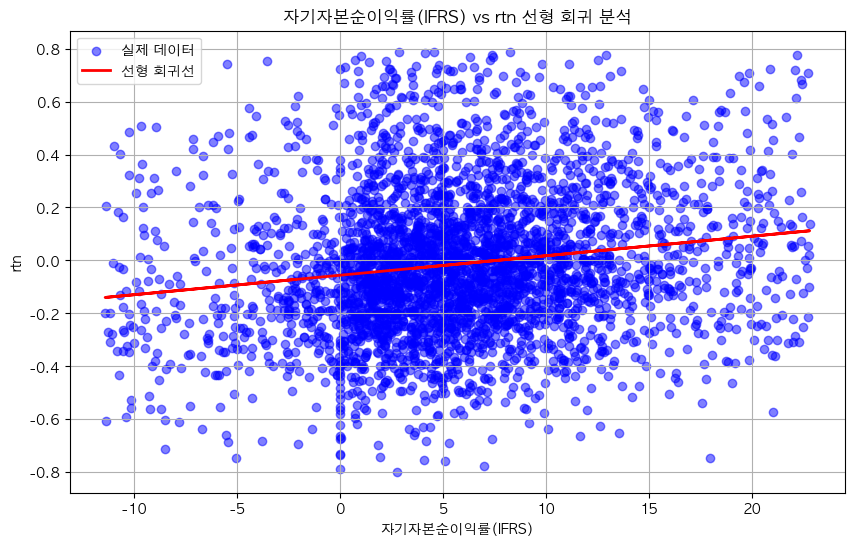

In [23]:
# 데이터 추출 (시리즈 형태)
x = merged['자기자본순이익률(IFRS)']      # 독립변수 (시리즈)
y = merged['수익률']     # 종속변수 (시리즈)

# 이상치 제거
x_filtered, y_filtered = remove_outliers(x, y)

# DataFrame으로 변환 (모델 입력용)
X = x_filtered.to_frame()  # 2D 배열 형태로 변환
y = y_filtered.to_frame()

# 선형회귀 모델 생성 및 학습
model = LinearRegression()
model.fit(X, y)

# 예측값 계산
y_pred = model.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(x_filtered, y_filtered, color='blue', label='실제 데이터', alpha=0.5)
plt.plot(x_filtered, y_pred, color='red', linewidth=2, label='선형 회귀선')
plt.title('자기자본순이익률(IFRS) vs rtn 선형 회귀 분석')
plt.xlabel('자기자본순이익률(IFRS)')
plt.ylabel('rtn')
plt.legend()
plt.grid(True)
plt.show()

